# Coursework 1 - Mathematics for Machine Learning

## CID: insert your CID here

**Colab link:** insert colab link here

***
***

## Part 1: Quickfire questions [3 points]

#### Question 1 (True risk / Empirical risk):

Enter your answer here

#### Question 2 ('Large' or 'rich' hypothesis class):

Enter your answer here

#### Question 3 (Dataset splitting):

Enter your answer here

#### Question 4 (Occam’s razor):

Enter your answer here

#### Question 5 (Generalisation error):

Enter your answer here

#### Question 6 (Rademacher complexity pt1):

Enter your answer here

#### Question 7 (Rademacher complexity pt2):

Enter your answer here

#### Question 8 (Regularisation term in the loss function):

Enter your answer here

#### Question 9 (Momentum gradient descent):

Enter your answer here

#### Question 10 (Adam):

Enter your answer here

#### Question 11 (AdaGrad):

Enter your answer here

#### Question 12 (Decaying Learning Rate):

Enter your answer here

***
***

## Part 2: Short-ish proofs [6 points]


### Question 2.1: Bounds on the risk [1 point]


***

### Question 2.2: On semi-definiteness [1 point]

***

### Question 2.3: A quick recap of momentum [1 point]

***

### Question 2.4: Convergence proof [3 points]

***
***

## Part 3: A deeper dive into neural network implementations [3 points]

In [1]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
# Download datasets
train_set_mnist = torchvision.datasets.MNIST(root="./data", download=True,
                                         train=True, transform=transforms.Compose([transforms.ToTensor()]));

test_set_mnist = torchvision.datasets.MNIST(root="./data",download=True,
                                        train=False,transform=transforms.Compose([transforms.ToTensor()]),);

train_set_cifar = torchvision.datasets.CIFAR10(root="./data", download=True,
                                         train=True, transform=transforms.Compose([transforms.ToTensor()]));

test_set_cifar = torchvision.datasets.CIFAR10(root="./data",download=True,
                                        train=False,transform=transforms.Compose([transforms.ToTensor()]),);

# Normalizing data:
train_set_mnist.data = nn.functional.normalize(train_set_mnist.data.to(float), p=1)
test_set_mnist.data = nn.functional.normalize(test_set_mnist.data.to(float), p=1)

Files already downloaded and verified
Files already downloaded and verified


#### Data preprocess

In [3]:
class ImageDataset(Dataset):
    """
        A PyTorch Dataset class for loading and normalizing MNIST or CIFAR datasets.
        This class preprocesses the data in the following way:
        * Choosing the correct trainset or testset.

        * Converting the targets from integers to arrays with length nclass
          s.t. the all of the components are zero except the target componenet which is one.
          e.g. for raw_target=4, target=[0, 0, 0, 0, 1, 0, 0, 0, 0, 0].

        * Casting the data and targets to torch.float32 (prevents future problems)

        * If normalize=True, normalizes the dataset by the p1 norm.

        Args:
            dataset_type (str): Type of dataset, either "mnist" or "cifar".
            train (bool): If True, load the training set; otherwise, load the test set.
            normalize (bool): If True, normalize the data.
            nclasses (int): Number of classes in the dataset.
    """

    def __init__(self, dataset_type, train: bool, normalize: bool, nclasses=10):
        match (dataset_type, train):
            case ("mnist", True):
                self.data =  train_set_mnist.data
                raw_targets = train_set_mnist.targets

            case ("mnist", False):
                self.data =  test_set_mnist.data
                raw_targets = test_set_mnist.targets

            case ("cifar", True):
                self.data =  train_set_cifar.data
                raw_targets = train_set_cifar.targets

            case ("cifar", False):
                self.data =  test_set_cifar.data
                raw_targets = test_set_cifar.targets

            case _:
                raise ValueError("Dataset must be 'mnist' or 'cifar'")

        self.targets = torch.zeros(len(raw_targets), nclasses, dtype=torch.float32)
        for i, t in enumerate(raw_targets):
            self.targets[i, int(t)] = 1.                            # Changing the targets into rows with 0 everywhere except the target

        self.data = torch.tensor(self.data, dtype=torch.float32)            # Casting to float to prevent future problems.

        if normalize:
            self.data = nn.functional.normalize(self.data, p=1)



    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def test_dataset():
    """
        Test the ImageDataset class by creating an instance and printing a sample.
    """
    traindata = ImageDataset("cifar", False, True)
    print(traindata[10])

# Unvomment for test:
# test_dataset()

***

### Part 3.1: Implementations [1 point]

#### Task 1

In [4]:
# Set seed
SEED = int('02530622')
np.random.seed(SEED)
torch.manual_seed(SEED);

In [5]:
class Net(nn.Module):
    """
      A simple feedforward neural network model.

      Args:
          dim (tuple): Input dimensions (e.g., (28, 28) for MNIST).
          nclass (int): Number of classes in the output.
          width (int): Width of the hidden layers.
          depth (int): Number of hidden layers.
    """

    def __init__(self, dim, nclass, width, depth):
      super().__init__()
      self.dim = dim
      self.nclass = nclass
      self.width = width
      self.depth = depth
      self.input_length = np.prod(dim)

      self.flatten = nn.Flatten()
      self.linear_in = nn.Linear(self.input_length, width)
      self.linear_hidden = nn.Linear(width, width)
      self.relu = nn.ReLU()
      self.linear_out = nn.Linear(width, nclass)

    def forward(self, input):
      """
        Forward pass of the neural network.

        Args:
            input (torch.Tensor): Input tensor. Changing the name to "x" for convenience.

        Returns:
            torch.Tensor: the output of the network for given input.
      """

      x = input   # Changing to a more convenience name
      flat_x = self.flatten(x)
      lifted_x = self.linear_in(flat_x)

      processed_x = lifted_x
      for _ in range(self.depth):
        processed_x = self.relu(self.linear_hidden(processed_x))

      return self.linear_out(processed_x)

def test_net(net=None):
  """
    Test the Net class by creating an instance and making a forward pass with a sample.

    Args:
        net (Net, optional): A pre-trained Net instance. If None, create a new instance.
  """

  mnist_net = Net((28, 28), 10, 16, 2) if net is None else net
  sample_index = np.random.randint(10000)

  x = train_set_mnist.data[sample_index, :, :]
  x = torch.unsqueeze(x, 0)
  print(mnist_net(x), train_set_mnist.targets[sample_index])


# test_net()

#### Tasks 2-5
All of these tasks are implemented in the NeuralNetworkTrainer class for convenience.

In [6]:
class NeuralNetworkTrainer():
  def __init__(
      self,
      dataset_type,
      width,
      depth,
      criterion, # Notice we assume that reduction="mean"
      optimizer,
      batch_size=64,
      lr=0.001,
      max_epoch=1,
      normalize=True
      ):
    """
      A high-level class for creating, training, and evaluating neural networks on MNIST or CIFAR datasets.

      Args:
          dataset_type (str): Type of dataset, either "mnist" or "cifar". dim is set accordingly.
          width (int): Width of the hidden layers in the neural network. Hyperparamater!
          depth (int): Number of hidden layers in the neural network. Hyperparamater!
          criterion (torch loss function): Loss function for training. Assume the loss uses reduction="mean" !
          optimizer (torch.optim.Optimizer): Optimization algorithm for training.
          batch_size (int, optional): Batch size for training and testing. Default is 64. Hyperparamater!
          lr (float, optional): Learning rate for the optimizer. Default is 0.001. Hyperparamater!
          max_epoch (int, optional): Maximum number of training epochs. Default is 1. Hyperparamater!
          normalize (bool, optional): If True, normalize the data. Default is True.
    """

    match dataset_type:
      case "mnist":
        dim = (28, 28)
        nclass = 10

      case "cifar":
        dim = (32, 32, 3)
        nclass = 10

      case _:
        raise ValueError("Dataset must be 'mnist' or 'cifar'")

    self.trainset = ImageDataset(dataset_type, train=True, normalize=normalize)
    self.testset = ImageDataset(dataset_type, train=False, normalize=normalize)
    self.batch_size = batch_size
    self.trainloader, self.testloader = self.loading_data()

    self.net = Net(dim, nclass, width, depth)

    self.lr = lr
    self.max_epoch = max_epoch
    self.optimizer = optimizer(self.net.parameters(), lr=self.lr)
    self.criterion = criterion


  def loading_data(self): # Notice that all of the required arguments are now attributes!
    """
      Create DataLoader instances for the training and testing datasets.

      Returns:
          tuple: Tuple containing DataLoader instances for training and testing.
    """

    trainloader = DataLoader(self.trainset, self.batch_size, shuffle=True)
    testloader = DataLoader(self.testset, self.batch_size, shuffle=False)

    return trainloader, testloader


  def train_epoch(self):  # Notice that all of the required arguments are now attributes!
    """
      Perform one training epoch.

      Returns:
          torch.Tensor: Training loss for the epoch based on given loss function.
    """

    self.net.train()

    for X, y in self.trainloader:
      y_hat = self.net(X)
      local_loss = self.criterion(y_hat, y)

      local_loss.backward()
      self.optimizer.step()
      self.optimizer.zero_grad()

    return self.criterion(
      self.net(self.trainloader.dataset.data),
      self.trainloader.dataset.targets
      )


  def test_epoch(self):
    """
      Perform one testing epoch.

      The error is computed as follows:
      torch.max(..., 1)[1] is doing argmax over each row and returns a list if ints, s.t.
      each int corresponds to the index that has maximal value in this row.
      argmax on a prediction returns the most likely class, argmax on the targets give the target.
      So, the number of zeros in the expression argmax(predict) - argmax(target) will give back the
      number of succsesful predictions, and the number of nonzero elements will give the errors!
      Example (batch=2, nclass=3):

      predictions =     [[0.6, 0.4, 0.,],
                        [0.7, 0.2, 0.1,]]

      targets =     [[1, 0., 0.,],
                    [0., 1, 0.,]]

      argmax(predictions) - argmax(targets) = [0 - 0, 0 - 1] = [0, -1]
      => number of errors = numbers of nonzero elements = 1



      Returns:
          tuple: Tuple containing testing loss and number of classification errors.
    """

    y = self.testloader.dataset.data
    targets = self.testloader.dataset.targets

    y_hat = self.net(y)
    mean_loss = self.criterion(y_hat, targets) # Asuuming reduction="mean"

    target_class = torch.max(targets, 1)[1]
    predicted_class = torch.max(y_hat, 1)[1] # Argmax gives predicted_class

    num_errors = len(torch.nonzero(predicted_class - target_class))


    return mean_loss, num_errors


  def train_me(self, logs=True):
    """
      Train the neural network for  max_epoch and print training and testing statistics.
    """

    samples_len = self.testset.data.shape[0]
    for i in range(self.max_epoch):
      epoch = i + 1
      train_loss = self.train_epoch()
      test_loss, test_err = self.test_epoch()

      if logs:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.04} |"
              f"Test Loss: {test_loss:.04} | Test Error: {test_err/samples_len:.04}")

    return np.array([float(train_loss), float(test_loss)])


def test_trainednetwork():
  cifar_net = NeuralNetworkTrainer(
      dataset_type="cifar",
      width=16,
      depth=2,
      criterion=nn.CrossEntropyLoss(),
      optimizer=optim.Adam,
      max_epoch=10
  )

  cifar_net.train_me()

# Uncomment for network test
# test_trainednetwork()

***

### Part 3.2: Numerical exploration [2 points]

#### Task 6 - Deep Networks Analysis

The following hyperparameters will be kept fixed:

| Hyperparameter | Fixed Value |
|---|---|
| `width` | 256 |
| `criterion` | nn.CrossEntropyLoss() |
| `optimizer` | optim.Adam |
| `batch_size` | 64 |
| `lr` | 0.001 |
| `max_epoch` | 10 |


In [7]:
# Fixed Hyperparameters:
hyperparams = {
    "dataset_type": "mnist",
    "width": 256,
    "criterion": nn.CrossEntropyLoss(),
    "optimizer": optim.Adam,
    "batch_size": 64,
    "lr": 0.001,
    "max_epoch": 10,
    "normalize": True
}

depths = [1, 5, 10]
errors = {}
for d in depths:
    hyperparams["depth"] = d
    mnist_net = NeuralNetworkTrainer(**hyperparams)

    errors[d] = mnist_net.train_me(logs=False)
    print(f"Depth: {d} | Train Loss: {errors[d][0]:.04} | "
          f"Test Loss: {errors[d][1]:.04}")


<ipython-input-3-16c4b5bd6b22>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float32)            # Casting to float to prevent future problems.


Depth: 1 | Train Loss: 0.03656 | Test Loss: 0.1233
Depth: 5 | Train Loss: 0.04159 | Test Loss: 0.126
Depth: 10 | Train Loss: 0.05324 | Test Loss: 0.1285


Text(0, 0.5, 'Loss')

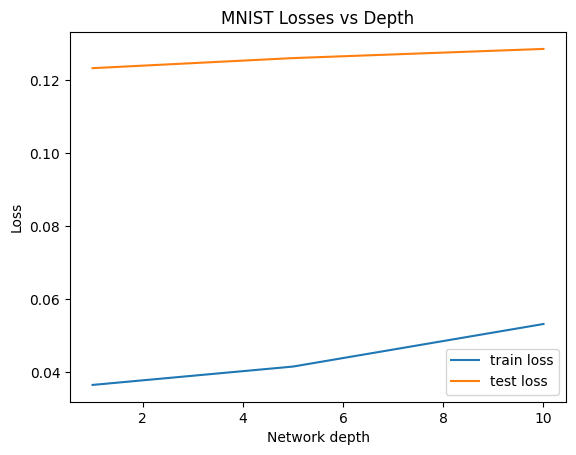

In [8]:
plt.title("MNIST Losses vs Depth")
train_error = [errors[d][0] for d in depths]
test_error = [errors[d][1] for d in depths]
plt.plot(depths, train_error, label="train loss")
plt.plot(depths, test_error, label="test loss")
plt.legend()
plt.xlabel("Network depth")
plt.ylabel("Loss")

Overfitting???

#### Task 9 - Wide Networks Analysis

In [9]:
# Fixed Hyperparameters:
hyperparams = {
    "dataset_type": "mnist",
    "depth": 1,
    "criterion": nn.CrossEntropyLoss(),
    "optimizer": optim.Adam,
    "batch_size": 64,
    "lr": 0.001,
    "max_epoch": 1,
    "normalize": True
}

widths = [2 ** i for i in range(2, 11)]
errors = {}
for w in widths:
    hyperparams["width"] = w
    mnist_net = NeuralNetworkTrainer(**hyperparams)

    errors[w] = mnist_net.train_me(logs=False)
    print(f"Width: {w} | Train Loss: {errors[w][0]:.04} | "
          f"Test Loss: {errors[w][1]:.04}")


<ipython-input-3-16c4b5bd6b22>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float32)            # Casting to float to prevent future problems.


Width: 4 | Train Loss: 1.24 | Test Loss: 1.242
Width: 8 | Train Loss: 0.5586 | Test Loss: 0.5528
Width: 16 | Train Loss: 0.4449 | Test Loss: 0.4412
Width: 32 | Train Loss: 0.356 | Test Loss: 0.3545
Width: 64 | Train Loss: 0.3165 | Test Loss: 0.3164
Width: 128 | Train Loss: 0.2728 | Test Loss: 0.2771
Width: 256 | Train Loss: 0.2225 | Test Loss: 0.2315
Width: 512 | Train Loss: 0.1901 | Test Loss: 0.2127
Width: 1024 | Train Loss: 0.1676 | Test Loss: 0.1887


(0.1, 0.5)

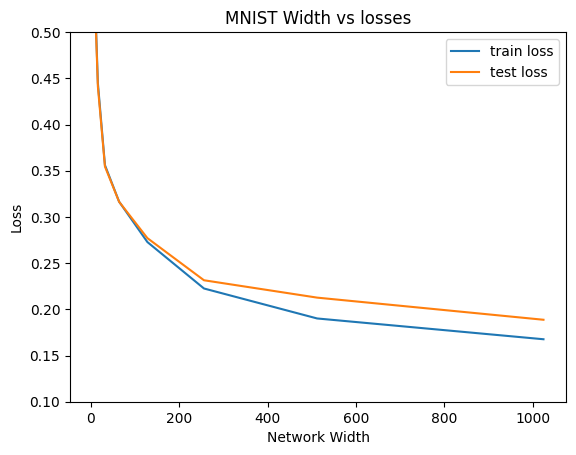

In [10]:
plt.title("MNIST Width vs losses")
train_error = [errors[w][0] for w in widths]
test_error = [errors[w][1] for w in widths]
plt.plot(widths, train_error, label="train loss")
plt.plot(widths, test_error, label="test loss")
plt.legend()
plt.xlabel("Network Width")
plt.ylabel("Loss")
plt.ylim([0.1, 0.5])

Overfitting? Doesn't seem like that.

***
***

## Part 4: The link between Neural Networks and Gaussian Processes [8 points]

### Part 4.1: Proving the relationship between a Gaussian process and a neural network [4 points]

### Task 1: Proper weight scaling

### Task 2: Derive the GP relation for a single hidden layer

### Task 3: Why in succession

### Task 4: Derive the GP relation for multiple hidden layers

***

### Part 4.2: Analysing the performance of the Gaussian process and a neural network [4 points]

In [11]:
# Please use float64 as default dtype for this part of the assignment
torch.set_default_dtype(torch.float64)

# Another hint: when  computing [ K^L(X,X) + noise^2 Id ]^-1 y and  [ K^L(X,X) + noise^2 Id ]^-1 K^L(X,X*)
# You can TRY cholesky solve as it should be p.d. (except case for numerical errors) - maybe you can use try:/except:
# You can also try to enforce symmetry in posterior covariance by doing (K + K.t())/2

In [12]:
# You can of course add more cells of both code and markdown.